# Overview
We want to see what the trends are over the span of the last month on Reddit. Then, we will compare it against data scraped from the news to see if Reddit discussions "predict" what's depicted in the news (i.e., is discussed ahead of time)

In [1]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

Matplotlib is building the font cache; this may take a moment.


In [14]:
posts_df = pd.read_csv("reddit_posts_cleaned.csv")
comments_df = pd.read_csv("reddit_comments_cleaned.csv")
news_df = pd.read_csv("news_cleaned.csv")

In [4]:
posts_df.head()

,subreddit,title,text,created_utc,id
0,pregnant,control snoring,snore always ever since kid usually mostly sno...,1.739371e+09,1ins3li
1,pregnant,pregnancy hormone,third trimester feeling extra clingy workaholi...,1.739371e+09,1ins3a5
2,pregnant,biological father test,possibility pregnancy caused two people 50 50 ...,1.739364e+09,1inprew
3,pregnant,people say loved pregnant must lying selective...,5 half week pregnant point exactly love waking...,1.739370e+09,1inrzzd
4,pregnant,zofran,even 8 week barely holding together day sickne...,1.739370e+09,1inrz7w


In [5]:
posts_df['date'] = pd.to_datetime(posts_df['created_utc'], unit='s').dt.date

In [6]:
posts_df.head()

,subreddit,title,text,created_utc,id,date
0,pregnant,control snoring,snore always ever since kid usually mostly sno...,1.739371e+09,1ins3li,2025-02-12
1,pregnant,pregnancy hormone,third trimester feeling extra clingy workaholi...,1.739371e+09,1ins3a5,2025-02-12
2,pregnant,biological father test,possibility pregnancy caused two people 50 50 ...,1.739364e+09,1inprew,2025-02-12
3,pregnant,people say loved pregnant must lying selective...,5 half week pregnant point exactly love waking...,1.739370e+09,1inrzzd,2025-02-12
4,pregnant,zofran,even 8 week barely holding together day sickne...,1.739370e+09,1inrz7w,2025-02-12


In [7]:
comments_df.shape

(31830, 2)

In [8]:
# group comments by post, so that there exists one "comment" entry per post
aggregated_comments = comments_df.groupby("post_id")["comment"].apply(lambda x: " ".join(x)).reset_index()
aggregated_comments.rename(columns={"comment": "comments"}, inplace=True)

In [9]:
aggregated_comments.shape

(4032, 2)

In [10]:
aggregated_comments.head()

,post_id,comments
0,1esrwu7,intrusive thought deal constantly thinking wor...
1,1ess0u2,similar feeling think possibly something along...
2,1et0l4r,sorry dealing friend alone incredibly tough ti...
3,1etl099,baby made realize poorly mother cared unloving...
4,1eulcdg,doctor id recommend thyroid iron level checked...


In [11]:
# we want to analyze each post together with its comments, should we should combine the content from both dataframes
posts_df.rename(columns={'id': 'post_id'}, inplace=True)
combined_df = posts_df.merge(aggregated_comments, on='post_id', how='left')

In [12]:
combined_df.head()

,subreddit,title,text,created_utc,post_id,date,comments
0,pregnant,control snoring,snore always ever since kid usually mostly sno...,1.739371e+09,1ins3li,2025-02-12,NaN
1,pregnant,pregnancy hormone,third trimester feeling extra clingy workaholi...,1.739371e+09,1ins3a5,2025-02-12,NaN
2,pregnant,biological father test,possibility pregnancy caused two people 50 50 ...,1.739364e+09,1inprew,2025-02-12,NaN
3,pregnant,people say loved pregnant must lying selective...,5 half week pregnant point exactly love waking...,1.739370e+09,1inrzzd,2025-02-12,people bad symptom 10 week tomorrow barely bad...
4,pregnant,zofran,even 8 week barely holding together day sickne...,1.739370e+09,1inrz7w,2025-02-12,NaN


## Aggregation of Posts and Comments Data
We want to combine the title, text, and comments for each post to ensure consistency.

In [13]:
combined_df['comments'] = combined_df['comments'].fillna('')
combined_df['text'] = combined_df['text'].fillna('')
combined_df['title'] = combined_df['title'].fillna('')

combined_df['full_text'] = combined_df['title'] + ' ' + combined_df['text'] + ' ' + combined_df['comments']

In [14]:
combined_df.head()

,subreddit,title,text,created_utc,post_id,date,comments,full_text
0,pregnant,control snoring,snore always ever since kid usually mostly sno...,1.739371e+09,1ins3li,2025-02-12,,control snoring snore always ever since kid us...
1,pregnant,pregnancy hormone,third trimester feeling extra clingy workaholi...,1.739371e+09,1ins3a5,2025-02-12,,pregnancy hormone third trimester feeling extr...
2,pregnant,biological father test,possibility pregnancy caused two people 50 50 ...,1.739364e+09,1inprew,2025-02-12,,biological father test possibility pregnancy c...
3,pregnant,people say loved pregnant must lying selective...,5 half week pregnant point exactly love waking...,1.739370e+09,1inrzzd,2025-02-12,people bad symptom 10 week tomorrow barely bad...,people say loved pregnant must lying selective...
4,pregnant,zofran,even 8 week barely holding together day sickne...,1.739370e+09,1inrz7w,2025-02-12,,zofran even 8 week barely holding together day...


## Generate Topics by Month for Reddit

In [73]:
# group by month
combined_df["month"] = pd.to_datetime(combined_df["date"]).dt.month

In [74]:
combined_df.head()

,subreddit,title,text,created_utc,post_id,date,comments,full_text,month
0,pregnant,control snoring,snore always ever since kid usually mostly sno...,1.739371e+09,1ins3li,2025-02-12,,control snoring snore always ever since kid us...,2
1,pregnant,pregnancy hormone,third trimester feeling extra clingy workaholi...,1.739371e+09,1ins3a5,2025-02-12,,pregnancy hormone third trimester feeling extr...,2
2,pregnant,biological father test,possibility pregnancy caused two people 50 50 ...,1.739364e+09,1inprew,2025-02-12,,biological father test possibility pregnancy c...,2
3,pregnant,people say loved pregnant must lying selective...,5 half week pregnant point exactly love waking...,1.739370e+09,1inrzzd,2025-02-12,people bad symptom 10 week tomorrow barely bad...,people say loved pregnant must lying selective...,2
4,pregnant,zofran,even 8 week barely holding together day sickne...,1.739370e+09,1inrz7w,2025-02-12,,zofran even 8 week barely holding together day...,2


## Creating the Model! First Pass

In [38]:
np.random.seed(23)

In [20]:
# try trigrams to get more specific phrases compared to unigram and bigram which are more general
vec = CountVectorizer(stop_words='english', ngram_range=(2,3))

In [16]:
topic_model = BERTopic(vectorizer_model=vec, language="english")

In [18]:
topics, probs = topic_model.fit_transform(combined_df['full_text'])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [19]:
# inspect topic summary
# shows representative words for each topic -- should check that there are no mod-related topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1929,-1_feel like_month old_sound like_year old,"[feel like, month old, sound like, year old, m...",[daily thread 2 january 10 2025 daily thread m...
1,0,271,0_month old_wake window_baby sleep_week old,"[month old, wake window, baby sleep, week old,...",[sleeping shift much sleep getting husband won...
2,1,184,1_feel like_daily thread_week today_previous p...,"[feel like, daily thread, week today, previous...",[daily thread 2 november 07 2024 daily thread ...
3,2,93,2_brown spotting_week pregnant_pregnancy test_...,"[brown spotting, week pregnant, pregnancy test...",[pregnant 17 morning went sexual health clinic...
4,3,87,3_39 week_vaginal birth_birth plan_getting epi...,"[39 week, vaginal birth, birth plan, getting e...",[opt 39 week induction almost 38 week ob offer...
...,...,...,...,...,...
78,77,10,77_week old_fall asleep_baby monitor_white noise,"[week old, fall asleep, baby monitor, white no...",[everything hard feel like everything heard pr...
79,78,10,78_tongue tie_gaining weight_lip tie_gaining w...,"[tongue tie, gaining weight, lip tie, gaining ...",[tongue tie revision experience hi daughter 6 ...
80,79,10,79_wife want_baby angry_love baby_life want,"[wife want, baby angry, love baby, life want, ...",[handle jealousy friend beyond point even tryi...
81,80,10,80_postpartum rage_feel like_breaking cycle_ti...,"[postpartum rage, feel like, breaking cycle, t...",[help 5 month pp 2nd baby everyday feel fuse g...


## Model Tuning
We have 68 different topics, which is high and probably has some overlap. Reduce the number of topics to merge similar topics.

In [21]:
topic_model = BERTopic(vectorizer_model=vec, language="english", nr_topics=30, min_topic_size=5)

In [20]:
topics, probs = topic_model.fit_transform(combined_df['full_text'])

In [21]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1626,-1_feel like_month old_felt like_year old,"[feel like, month old, felt like, year old, me...",[please someone help desperate please someone ...
1,0,830,0_feel like_daily thread_week today_week day,"[feel like, daily thread, week today, week day...",[daily thread 2 december 13 2024 daily thread ...
2,1,509,1_feel like_sound like_month old_mental health,"[feel like, sound like, month old, mental heal...",[pregnant fwb want keep want abortion fwb 27m ...
3,2,296,2_month old_week old_wake window_baby sleep,"[month old, week old, wake window, baby sleep,...",[sleeping shift much sleep getting husband won...
4,3,296,3_month old_week old_formula fed_breast milk,"[month old, week old, formula fed, breast milk...",[colic fucked 6 week old screaming absolute bl...
5,4,241,4_pelvic floor_stretch mark_feel like_second t...,"[pelvic floor, stretch mark, feel like, second...",[feeling fit right scaredsad let go pregnancy ...
6,5,163,5_diaper bag_month old_car seat_make sure,"[diaper bag, month old, car seat, make sure, n...",[one tell admit completely spaced day one told...
7,6,117,6_pelvic floor_degree tear_week pp_feel like,"[pelvic floor, degree tear, week pp, feel like...",[let fear pain hold back sex unsolicited advic...
8,7,77,7_week old_rsv vaccine_month old_month vaccine,"[week old, rsv vaccine, month old, month vacci...",[preparing first vaccine looking medical advic...
9,8,65,8_morning sickness_stool softener_nauseous day...,"[morning sickness, stool softener, nauseous da...",[training empty stomach 5w6d today nausea gone...


In [22]:
combined_df['topic'] = topics

In [24]:
for topic_id in range(0, 10):
    print('topic', topic_id)
    example_texts = combined_df[combined_df["topic"] == topic_id]["full_text"].sample(5)
    example_texts.to_csv(f"topic_{topic_id}_examples.csv", index=False)

topic 0
topic 1
topic 2
topic 3
topic 4
topic 5
topic 6
topic 7
topic 8
topic 9


In [26]:
topic_model.get_topic_info().to_csv('bert_reddit_results.csv')

## More In-Depth Emotion Analysis

In [28]:
from transformers import pipeline

In [29]:
# pre-trained classifier
emotion_model = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


In [77]:
# get emotion for each post
def get_emotion_with_progress(text, index):
    if index % 100 == 0:
        print(f"Processing post {index}...")

    predictions = emotion_model(text)

    if isinstance(predictions, list) and len(predictions) > 0 and isinstance(predictions[0], list):
        top_emotion = max(predictions[0], key=lambda x: x['score'])
        return top_emotion.get("label", "unknown")
    else:
        return "unknown"
combined_df["full_text"] = combined_df["full_text"].str[:1625] 
combined_df['emotion'] = [get_emotion_with_progress(text, i) for i, text in enumerate(combined_df["full_text"])]

print(combined_df[["full_text", "emotion"]].head())

Processing post 0...
Processing post 100...
Processing post 200...
Processing post 300...
Processing post 400...
Processing post 500...
Processing post 600...
Processing post 700...
Processing post 800...
Processing post 900...
Processing post 1000...
Processing post 1100...
Processing post 1200...
Processing post 1300...
Processing post 1400...
Processing post 1500...
Processing post 1600...
Processing post 1700...
Processing post 1800...
Processing post 1900...
Processing post 2000...
Processing post 2100...
Processing post 2200...
Processing post 2300...
Processing post 2400...
Processing post 2500...
Processing post 2600...
Processing post 2700...
Processing post 2800...
Processing post 2900...
Processing post 3000...
Processing post 3100...
Processing post 3200...
Processing post 3300...
Processing post 3400...
Processing post 3500...
Processing post 3600...
Processing post 3700...
Processing post 3800...
Processing post 3900...
Processing post 4000...
Processing post 4100...
Proc

In [78]:
combined_df.to_csv('reddit_emotions.csv')

In [2]:
emotion_df = pd.read_csv('reddit_emotions.csv')

In [11]:
emotion_df.head()

,Unnamed: 0,subreddit,title,text,created_utc,post_id,date,comments,full_text,topic,emotion
0,0,pregnant,control snoring,snore always ever since kid usually mostly sno...,1.739371e+09,1ins3li,2025-02-12,NaN,control snoring snore always ever since kid us...,2,fear
1,1,pregnant,pregnancy hormone,third trimester feeling extra clingy workaholi...,1.739371e+09,1ins3a5,2025-02-12,NaN,pregnancy hormone third trimester feeling extr...,1,anger
2,2,pregnant,biological father test,possibility pregnancy caused two people 50 50 ...,1.739364e+09,1inprew,2025-02-12,NaN,biological father test possibility pregnancy c...,16,fear
3,3,pregnant,people say loved pregnant must lying selective...,5 half week pregnant point exactly love waking...,1.739370e+09,1inrzzd,2025-02-12,people bad symptom 10 week tomorrow barely bad...,people say loved pregnant must lying selective...,-1,sadness
4,4,pregnant,zofran,even 8 week barely holding together day sickne...,1.739370e+09,1inrz7w,2025-02-12,NaN,zofran even 8 week barely holding together day...,8,sadness


In [3]:
emotion_df.groupby('topic')['emotion'].value_counts()

topic  emotion 
-1     fear        655
       sadness     514
       joy         151
       anger       141
       surprise    131
                  ... 
 27    fear          2
       neutral       2
 28    fear          3
       sadness       2
       joy           1
Name: count, Length: 150, dtype: int64

In [4]:
filtered_df = emotion_df[emotion_df['topic'].between(0, 9)]

emotion_counts_by_topic = filtered_df.groupby('topic')['emotion'].value_counts().unstack().fillna(0)

In [5]:
emotion_counts_by_topic

emotion,anger,disgust,fear,joy,neutral,sadness,surprise
topic,,,,,,,
0,23.0,0.0,444.0,116.0,6.0,175.0,66.0
1,75.0,0.0,161.0,53.0,4.0,188.0,28.0
2,21.0,0.0,109.0,21.0,21.0,75.0,49.0
3,29.0,2.0,100.0,23.0,36.0,78.0,28.0
4,12.0,0.0,47.0,76.0,10.0,70.0,26.0
5,9.0,0.0,47.0,38.0,17.0,26.0,26.0
6,8.0,0.0,37.0,2.0,0.0,63.0,7.0
7,7.0,0.0,36.0,3.0,3.0,26.0,2.0
8,0.0,1.0,28.0,0.0,0.0,35.0,1.0


In [6]:
filtered_df['emotion'].value_counts() / filtered_df.shape[0]

emotion
fear        0.394578
sadness     0.282380
joy         0.127259
surprise    0.088479
anger       0.069654
neutral     0.036521
disgust     0.001130
Name: count, dtype: float64

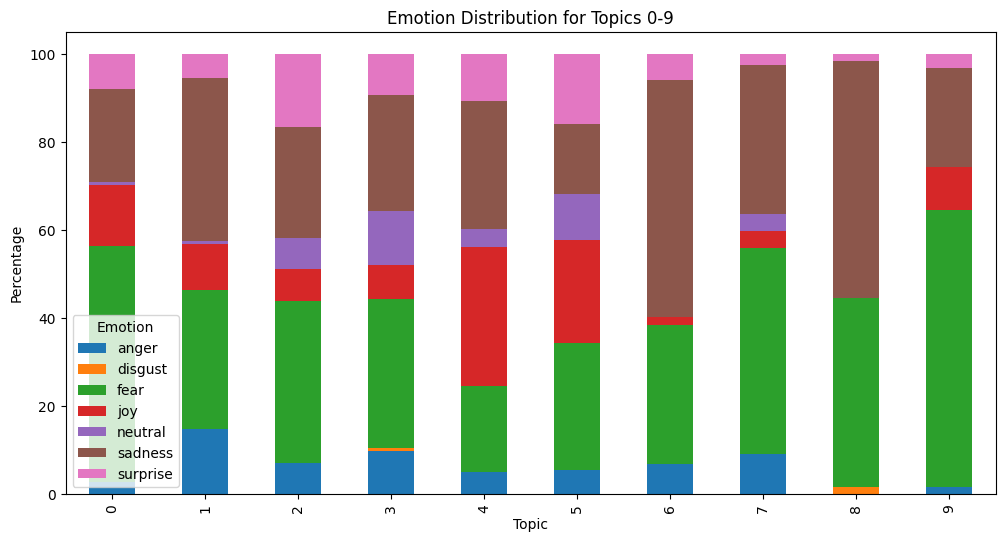

In [8]:
import matplotlib.pyplot as plt
# convert to percentage
emotion_counts_by_topic = emotion_counts_by_topic.div(emotion_counts_by_topic.sum(axis=1), axis=0) * 100
emotion_counts_by_topic.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title("Emotion Distribution for Topics 0-9")
plt.xlabel("Topic")
plt.ylabel("Percentage")
plt.legend(title="Emotion")
plt.show()

## Apply Model to News Data

In [15]:
news_df.head()

,title,description,content,published_at,source,url
0,son birth nearly perfect day later almost died...,picked phone 10 minute later two missed call v...,second night home hospital still aweinspiring ...,2025-01-20T02:31:02Z,Buzzfeed,https://www.buzzfeed.com/christinamcdowell/pos...
1,woman seeking abortion using natural contracep...,researcher seen shift reliable hormonal contra...,rise proportion woman seeking abortion despite...,2025-01-14T00:57:33Z,BBC News,https://www.bbc.com/news/articles/c391nlxrv4vo
2,husband teacher sole earner family 7 money tig...,five kid husband reached maximum salary teache...,author husband pictured still work teacher hea...,2025-01-13T18:04:02Z,Business Insider,https://www.businessinsider.com/my-husband-is-...
3,trump plan leave health disaster,exit cut huge chunk world health organization ...,summer 2020 15 recognized leader u public heal...,2025-01-22T00:14:05Z,Wired,https://www.wired.com/story/trump-plan-to-leav...
4,born late climate change may delaying birth,new research found exposure outdoor air pollut...,new curtin university research found exposure ...,2025-02-11T04:18:15Z,Science Daily,https://www.sciencedaily.com/releases/2025/02/...


In [16]:
# combine title, description, and content into a single column
news_df['full_text'] = news_df['title'] + ' ' + news_df['description'] + ' ' + news_df['content']

In [17]:
news_df.head()

,title,description,content,published_at,source,url,full_text
0,son birth nearly perfect day later almost died...,picked phone 10 minute later two missed call v...,second night home hospital still aweinspiring ...,2025-01-20T02:31:02Z,Buzzfeed,https://www.buzzfeed.com/christinamcdowell/pos...,son birth nearly perfect day later almost died...
1,woman seeking abortion using natural contracep...,researcher seen shift reliable hormonal contra...,rise proportion woman seeking abortion despite...,2025-01-14T00:57:33Z,BBC News,https://www.bbc.com/news/articles/c391nlxrv4vo,woman seeking abortion using natural contracep...
2,husband teacher sole earner family 7 money tig...,five kid husband reached maximum salary teache...,author husband pictured still work teacher hea...,2025-01-13T18:04:02Z,Business Insider,https://www.businessinsider.com/my-husband-is-...,husband teacher sole earner family 7 money tig...
3,trump plan leave health disaster,exit cut huge chunk world health organization ...,summer 2020 15 recognized leader u public heal...,2025-01-22T00:14:05Z,Wired,https://www.wired.com/story/trump-plan-to-leav...,trump plan leave health disaster exit cut huge...
4,born late climate change may delaying birth,new research found exposure outdoor air pollut...,new curtin university research found exposure ...,2025-02-11T04:18:15Z,Science Daily,https://www.sciencedaily.com/releases/2025/02/...,born late climate change may delaying birth ne...


In [22]:
topics, probs = topic_model.fit_transform(news_df['full_text'])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [23]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,15,-1_gen zers_yoga 25 year_yoga 25_25 year,"[gen zers, yoga 25 year, yoga 25, 25 year, men...",[kate photographed prince louis mark world can...
1,0,41,0_donald trump_robert kennedy_kennedy jr_rober...,"[donald trump, robert kennedy, kennedy jr, rob...",[five takeaway rfk jr first confirmation heari...
2,1,11,1_galaxy ring_galaxy s25_health study_super bowl,"[galaxy ring, galaxy s25, health study, super ...",[samsung expanding galaxy ring five important ...
3,2,13,2_green powder_vibration plate_personality dis...,"[green powder, vibration plate, personality di...",[people adhd living shorter life study find di...
4,3,16,3_postpartum depression_pregnant woman_excess ...,"[postpartum depression, pregnant woman, excess...",[born late climate change may delaying birth n...


In [24]:
news_df.shape

(96, 7)